In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import altair as alt

alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('html') 

RendererRegistry.enable('html')

# **Data Preparation**

In [3]:
url = 'https://raw.githubusercontent.com/Premalatha-success/Financial-Analytics-Loan-Approval-Prediction/main/loan_prediction.csv'
loan_data = pd.read_csv(url)

Removing spaces from column names helps avoid problems when referencing them later in the analysis. Checking for missing values is important to spot any gaps in the data that need fixing, making sure the data is ready for analysis.

In [4]:
# Checking for spaces in the column names
loan_data.columns = loan_data.columns.str.strip()

# Checking again for missing values in the dataset
missing_values = loan_data.isnull().sum()
print("Missing values in each feature:\n", missing_values)


Missing values in each feature:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Missing values in categorical features are filled with the most common value to keep the data consistent.

For numerical features, missing values are filled with the median, which is a reliable measure that is not influenced by extreme values. A final check ensures that all missing values have been handled, making the dataset ready for modeling.

In [5]:
# Handling missing values
# Filling missing values with the mode for categorical features
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    loan_data[column] = loan_data[column].fillna(loan_data[column].mode()[0])

# Filling missing values with the median for numerical features
loan_data['LoanAmount'] = loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].median())
loan_data['Loan_Amount_Term'] = loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].median())

# Verify if all missing values have been handled
print("Missing values after handling:\n", loan_data.isnull().sum())


Missing values after handling:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


The dataset is now allowing for accurate modeling without the risk of inaccuracies due to incomplete data. This step lays the foundation for subsequent data analysis and machine learning model training.

In [6]:
# Transform categorical variables into numerical representations using appropriate encoding techniques
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

label_encoder = LabelEncoder()
for column in categorical_columns:
    loan_data[column] = label_encoder.fit_transform(loan_data[column])
loan_data['Loan_Status'] = loan_data['Loan_Status'].map({'Y': 1, 'N': 0})


Categorical features are converted into numbers so that machine learning models can understand and use the data. The target variable, Loan_Status, is changed into a simple yes/no format, making it ready for classification.

# **Exploratory Data Analysis**
The goal is to explore the dataset to see how the data is spread out, find typical values, and understand how different features relate to each other. This helps identify patterns, unusual data points, or connections between features. Descriptive statistics are generated for both numerical and categorical features. The data is then visualised with histograms, box plots, and bar charts to get a clear picture of its distribution and spot any irregularities.

In [7]:
# Descriptive statistics for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
print("Descriptive statistics for numerical features:\n", loan_data[numerical_features].describe())


Descriptive statistics for numerical features:
        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
count       614.000000         614.000000  614.000000        614.000000
mean       5403.459283        1621.245798  145.752443        342.410423
std        6109.041673        2926.248369   84.107233         64.428629
min         150.000000           0.000000    9.000000         12.000000
25%        2877.500000           0.000000  100.250000        360.000000
50%        3812.500000        1188.500000  128.000000        360.000000
75%        5795.000000        2297.250000  164.750000        360.000000
max       81000.000000       41667.000000  700.000000        480.000000


# **Data Analysis Inferences**

The average applicant income is about USD 5,403, but it varies a lot, as shown by a standard deviation of USD 6,109. Incomes range from a minimum of USD 150 to a maximum of USD 81,000, showing a wide spread among applicants. The median income is USD 3,812.50, which is lower than the average, indicating that most incomes are on the lower side, with a few very high ones skewing the average.

For coapplicants, the average income is USD 1,621, with a large variation (standard deviation of USD 2,926). Some applicants have no coapplicant income at all, as shown by a minimum of USD 0. The median coapplicant income is USD 1,188.50, which is also lower than the average, suggesting that, like with applicants, most coapplicant incomes are lower, with a few high incomes skewing the average.

The average loan amount is about USD 145.75, with a standard deviation of USD 84.11, showing that loan amounts vary widely. Loan amounts range from USD 9 to USD 700, indicating a broad spectrum of loan sizes. The median loan amount is USD 128, which is less than the average, suggesting that there are a few large loans that increase the average.

The average loan term is approximately 342 months (around 28.5 years), with a standard deviation of 64.43 months. Loan terms range from 12 months to 480 months (40 years). Most loans have a term of 360 months (30 years), as shown by the 25th, 50th, and 75th percentiles, with only a few loans having shorter or longer terms.

In [8]:
# Descriptive statistics for categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
print("\nDescriptive statistics for categorical features:\n", loan_data[categorical_features].describe())



Descriptive statistics for categorical features:
            Gender     Married  Dependents   Education  Self_Employed  \
count  614.000000  614.000000  614.000000  614.000000     614.000000   
mean     0.817590    0.653094    0.744300    0.218241       0.133550   
std      0.386497    0.476373    1.009623    0.413389       0.340446   
min      0.000000    0.000000    0.000000    0.000000       0.000000   
25%      1.000000    0.000000    0.000000    0.000000       0.000000   
50%      1.000000    1.000000    0.000000    0.000000       0.000000   
75%      1.000000    1.000000    1.000000    0.000000       0.000000   
max      1.000000    1.000000    3.000000    1.000000       1.000000   

       Credit_History  Property_Area  Loan_Status  
count      614.000000     614.000000   614.000000  
mean         0.855049       1.037459     0.687296  
std          0.352339       0.787482     0.463973  
min          0.000000       0.000000     0.000000  
25%          1.000000       0.000000    

# **Data Analysis Inferences**

Gender
- The mean value is 0.82, which suggests that a majority of the applicants are male (assuming male is encoded as 1).
- The standard deviation of 0.39 indicates that there is some variation, but not a significant amount.
- Most of the data points are at the maximum value of 1, as indicated by the 25th, 50th, and 75th percentiles.

Married
- The mean of 0.65 indicates that most applicants are married.
- The standard deviation of 0.48 suggests a more balanced distribution between married and unmarried applicants.

Dependents
- The mean is 0.74, with a standard deviation of 1.01, indicating that the number of dependents varies more widely.
- The max value is 3, meaning there are applicants with up to 3 dependents.

Education
- The mean of 0.22 suggests that the majority of applicants are graduates (assuming graduate is encoded as 0).
- There is little variability in this feature, with most values being 0 (graduates).

Self Employed
- The mean is 0.13, indicating that most applicants are not self-employed.
- The standard deviation of 0.34 supports this, showing that the majority of the dataset consists of non-self-employed individuals.

Credit History
- The mean of 0.86 suggests that most applicants have a positive credit history (assuming a positive credit history is encoded as 1).
- The standard deviation of 0.35 suggests some variation, but most values are at the higher end.

Property Area
- The mean of 1.04 indicates a fairly even distribution across different property areas (assuming categories are encoded as 0, 1, and 2).
- The standard deviation of 0.79 suggests that the distribution is somewhat varied across different property areas.

Loan Status
- The mean of 0.69 suggests that about 69% of the loans were approved.
- The standard deviation of 0.46 indicates a significant portion of the data points are at one of the extremes (approved or not).


In [23]:
# Concatenate and display histograms
histograms = []
for feature in numerical_features:
    chart = alt.Chart(loan_data).mark_bar().encode(
        alt.X(f'{feature}:Q', bin=True),
        y='count()',
    ).properties(
        title=f'Histogram of {feature}',
        width=200,
        height=200
    )
    histograms.append(chart)

# Concatenate all histograms and display
alt.hconcat(*histograms).display()
# chart.save('histograms.png')

# from IPython.display import Image
# Image('histograms.png')

alt.HConcatChart(...)

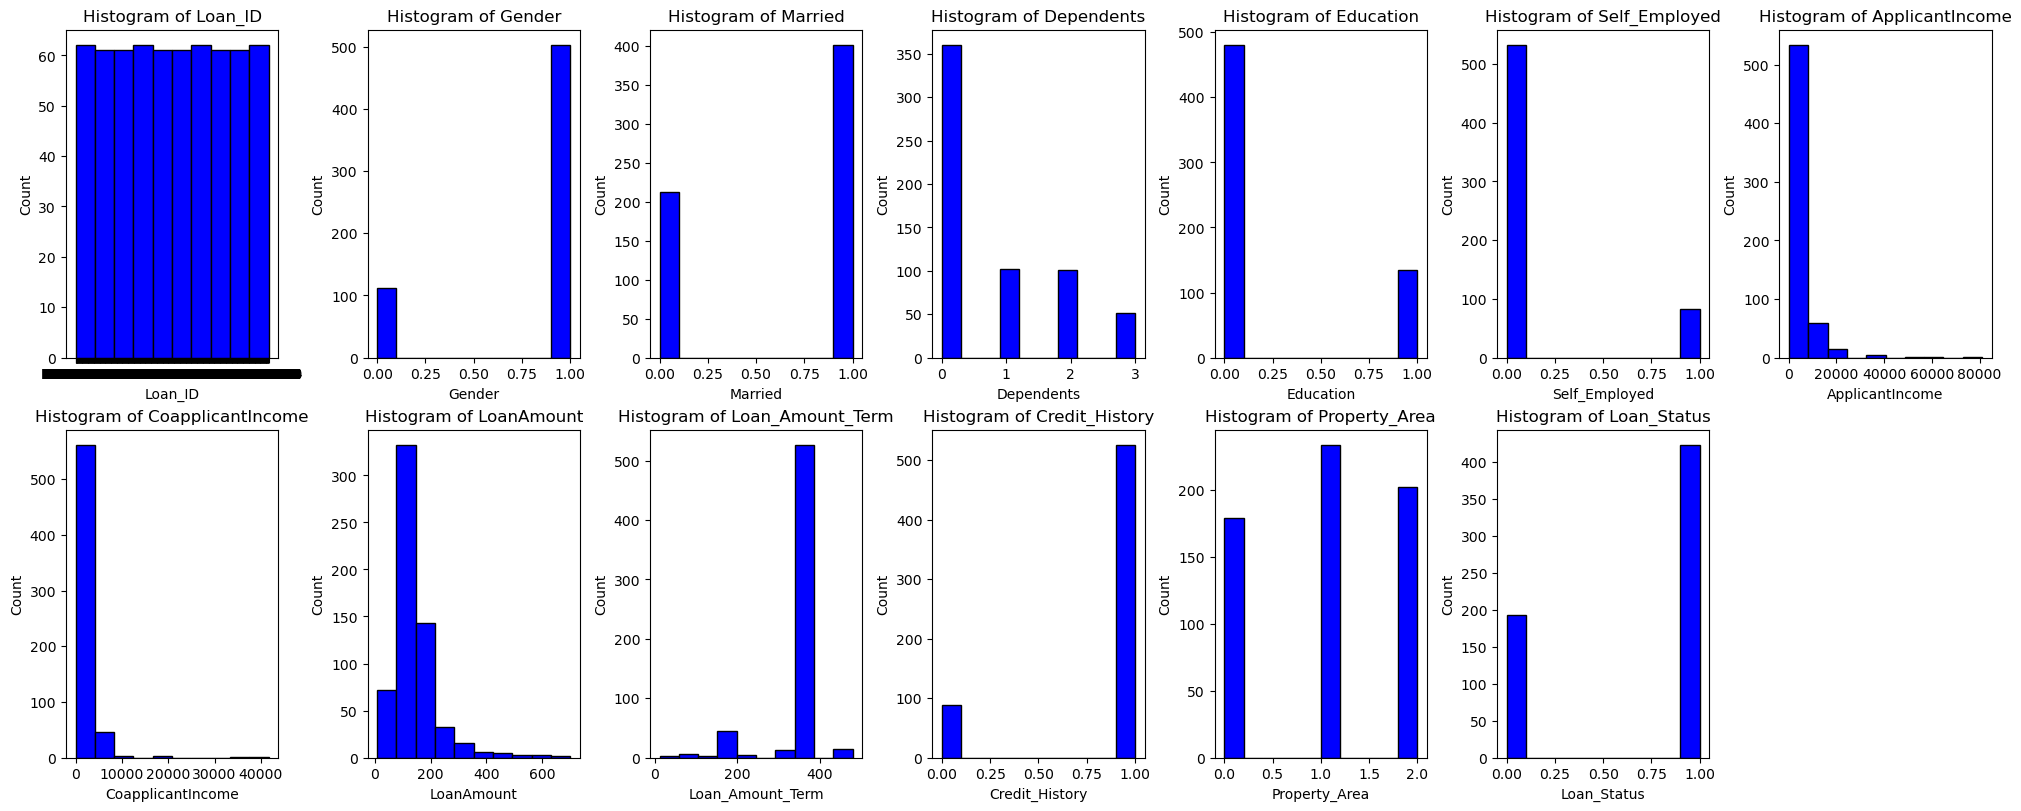

In [25]:
numerical_features = loan_data.columns

# Number of rows and columns for subplots
nrows = 2
ncols = 7  # Ensure at least enough columns for 13 plots

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature's histogram
for i, feature in enumerate(numerical_features):
    axes[i].hist(loan_data[feature], bins=10, color='blue', edgecolor='black')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

# Display the plot
plt.show()


In [ ]:
# Concatenate and display box plots
box_plots = []
for feature in numerical_features:
    chart = alt.Chart(loan_data).mark_boxplot().encode(
        y=alt.Y(f'{feature}:Q'),
    ).properties(
        title=f'Box plot of {feature}',
        width=200,
        height=200
    )
    box_plots.append(chart)

chart = alt.hconcat(*box_plots).display()
chart.save('boxplots.png')

from IPython.display import Image
Image('boxplots.png')

In [ ]:
# Concatenate and display bar plots
bar_plots = []
for feature in categorical_features:
    chart = alt.Chart(loan_data).mark_bar().encode(
        x=alt.X(f'{feature}:N'),
        y='count()',
    ).properties(
        title=f'Count plot of {feature}',
        width=200,
        height=200
    )
    bar_plots.append(chart)

chart = alt.hconcat(*box_plots).display()
chart.save('bar_plots.png')

from IPython.display import Image
Image('bar_plots.png')

### Coapplicant Income

Most loan applications have a coapplicant income of zero, meaning many applicants don't have a coapplicant. For those that do, most incomes are below USD 10,000, with a few going as high as USD 40,000.

### Marital Status

There are more married applicants than unmarried ones.

### Gender

There are significantly more male applicants than female applicants.

### Loan Term

Most loan terms are about 360 months (30 years), with some shorter or longer terms as outliers.

### Loan Amount

Loan amounts vary widely, with many loans between USD 100,000 and USD 200,000, and some large loans going up to USD 700,000.

### Applicant Income

Applicant incomes vary greatly, with most earning below USD 10,000, but some outliers earning up to USD 80,000. The distribution is skewed, with most applicants earning less than USD 20,000.

### Loan Status

More loans were approved (Loan_Status = 1) than rejected (Loan_Status = 0).

### Property Area

The data is fairly evenly spread across different property areas, with a slight preference for one area (category 1).

### Credit History

Most applicants have a positive credit history (Credit_History = 1).

### Self-Employment

The majority of applicants are not self-employed.

### Education

Most applicants are graduates (Education = 0).

# **Model Building**
Split the data into training and testing sets, standardise it, and train several models. This step gets the data ready for modeling and lets us compare different algorithms.

In [10]:
# Split the dataset into training and testing sets
X = loan_data.drop(columns=['Loan_ID', 'Loan_Status'])
y = loan_data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (491, 11)
Testing set shape: (123, 11)


The data is divided into training and testing sets, which is important for checking how well the model performs on new data. This step helps us see if the model can work well with data it hasn't seen before.

The data was split evenly, with 20% set aside for testing. This is a common approach, making sure there's enough data to both train the model and test how well it works.

In [11]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Data standardisation adjusts the features to a common range, which is especially important for models like SVM and Logistic Regression. This step makes sure that no single feature outweighs the others because of its scale.

In [12]:
# Initialise the models with increased iterations for Logistic Regression
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'KNN Classifier': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(algorithm='SAMME')
}


Different models are set up, each with its own strengths. This variety helps us thoroughly evaluate different methods, making sure we choose the best model based on how well it performs.

# **Model Evaluation and Comparison**
Evaluate the models on the test set using different performance measures and compare how well they work. This step helps find the model that performs the best across various factors.

In [13]:
# Function to evaluate the models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate each model
model_performance = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


Each model is evaluated using important performance measures:

**Accuracy**: Checks how often the model's predictions are correct overall.

**Precision**: Measures how accurate the model's positive predictions are.

**Recall**: Looks at how well the model finds all the positive cases.

**F1 Score**: Combines precision and recall into one measure to show the model's accuracy.

In [14]:
# Convert the performance dictionary to a DataFrame
model_performance_df = pd.DataFrame(model_performance).T
model_performance_df.reset_index(inplace=True)
model_performance_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame to long format for easier plotting
model_performance_melted = model_performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting the model performance using Altair
performance_chart = alt.Chart(model_performance_melted).mark_bar().encode(
    x=alt.X('Model:N', sort='-y'),
    y='Score:Q',
    color='Metric:N',
    column='Metric:N'
).properties(
    title='Model Comparison based on Multiple Metrics'
).resolve_scale(
    y='independent'
)

performance_chart.display()


alt.Chart(...)

The results are shown in a bar chart that compares different machine learning models (like Logistic Regression, AdaBoost, and SVM) across several metrics: Accuracy, F1 Score, Precision, and Recall.

Accuracy

- Logistic Regression, AdaBoost, and SVM had the highest accuracy, with scores around 0.85-0.87.
- The Decision Tree Classifier had the lowest accuracy, suggesting it's not as effective at predicting loan approvals.

F1 Score

- Most models, especially Logistic Regression and AdaBoost, have high F1 Scores, showing a good balance between precision and recall.
- This indicates that these models are not only accurate but also handle class imbalances well.

Precision

- Precision is consistently high for most models, meaning that when they predict a loan approval, they are usually correct.
- The Decision Tree Classifier has a slight drop in precision, further indicating its weaker performance.

Recall

- Logistic Regression and AdaBoost have the highest recall, meaning they are better at identifying loans that should be approved.
- Models with lower recall, like the Decision Tree Classifier, might miss some loans that should be approved, suggesting they may be underfitting.

# **Cross Validation and Hyperparameter Tuning**
To check if the model performs consistently across different parts of the data and to fine-tune the best model's settings for the best results. This step makes sure the model is reliable and optimised.

In [15]:
# Cross-validation for each model
def cross_validate_model(model, X, y, cv=5):
    cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
    cv_recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return cv_accuracy.mean(), cv_precision.mean(), cv_recall.mean(), cv_f1.mean()

# Cross-validate each model
cv_model_performance = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1 = cross_validate_model(model, X_train_scaled, y_train)
    cv_model_performance[model_name] = {
        'CV Accuracy': accuracy,
        'CV Precision': precision,
        'CV Recall': recall,
        'CV F1 Score': f1
    }


Cross-validation checks that the model performs consistently across different parts of the data, helping to prevent overfitting. This process gives a more accurate idea of how the model will work on new, unseen data.

In [16]:
# Convert cross-validation results to DataFrame
cv_model_performance_df = pd.DataFrame(cv_model_performance).T
cv_model_performance_df.reset_index(inplace=True)
cv_model_performance_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame to long format for easier plotting
cv_model_performance_melted = cv_model_performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting cross-validated model performance
cv_performance_chart = alt.Chart(cv_model_performance_melted).mark_bar().encode(
    x=alt.X('Model:N', sort='-y'),
    y='Score:Q',
    color='Metric:N',
    column='Metric:N'
).properties(
    title='Cross-Validated Model Comparison based on Multiple Metrics'
).resolve_scale(
    y='independent'
)

cv_performance_chart.display()


alt.Chart(...)

Cross-validation of performance metrics after optimisation

Accuracy

- Like before, Logistic Regression and AdaBoost Classifier have the highest accuracy, showing they are reliable across different data splits.
- The Decision Tree Classifier still has lower accuracy, which could mean it tends to overfit or underfit the data.

F1 Score

- Logistic Regression and AdaBoost Classifier continue to have strong F1 scores, showing they can balance precision and recall well across different folds.
- Other models have slightly lower F1 scores, suggesting they may not balance precision and recall as effectively.

Precision

- Precision is consistently high for all models, meaning that when these models predict an approval, they are usually correct.
- The consistency across models shows that precision is not a weak point for any of them.

Recall

- Logistic Regression and AdaBoost Classifier have the highest recall, meaning they are good at identifying most loans that should be approved.
- Lower recall in models like the Decision Tree Classifier suggests they might miss some approvals, indicating possible underfitting.

In [17]:
# Assuming the Gradient Boosting Classifier performed the best, we will proceed with tuning its hyperparameters
# Define the parameter grid for Gradient Boosting Classifier
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialise the model
gbc = GradientBoostingClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score}")


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best F1 Score: 0.8657727247220114


The best F1 Score with this set of parameters is 0.8658. This high F1 score shows that the model is doing a good job of balancing precision and recall, making it strong in accurately predicting both positive and negative outcomes.

# **Model Evaluation after Tuning**
To test the final, tuned model on the test set to make sure it works well with new data. This step gives a final check on how well the model solves the problem.

In [18]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Test Accuracy: 0.8130081300813008
Test Precision: 0.819047619047619
Test Recall: 0.9555555555555556
Test F1 Score: 0.8820512820512821


**Accuracy**

The model's accuracy on the test set is about 81.3%, means it correctly classifies over 81% of the loan applications.

**Precision**

Precision is around 81.9%, which means that when the model predicts a loan approval, it's correct for 81.9% of the time. This suggests that false positives are fairly low.

**Recall**

Recall is high at 95.6%, showing that the model is excellent at identifying loans that should be approved. This high recall means the model rarely misses loans that should be approved.

**F1 Score**

The F1 Score is 88.2%, indicating a good balance between precision and recall, making the model reliable and effective at predicting loan approvals.

**After hyperparameter tuning, the Gradient Boosting Classifier performs very well on the test set, with strong scores across all metrics. The high recall and F1 score, in particular, show that the model is very good at accurately identifying and classifying loan approvals while keeping a good balance with precision.**